# ROMY Processing - Prepare masked ZNE streams

Load ZUV data, process, mask with MLTI log and store as masked streams

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

from numpy import where
from andbro__read_sds import __read_sds

from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.load_lxx import __load_lxx
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __write_stream_to_sds(st, cha, path_to_sds):

    import os

    # check if output path exists
    if not os.path.exists(path_to_sds):
        print(f" -> {path_to_sds} does not exist!")
        return

    tr = st.select(channel=cha)[0]

    nn, ss, ll, cc = tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel
    yy, jj = tr.stats.starttime.year, str(tr.stats.starttime.julday).rjust(3,"0")

    if not os.path.exists(path_to_sds+f"{yy}/"):
        os.mkdir(path_to_sds+f"{yy}/")
        print(f"creating: {path_to_sds}{yy}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/{cc}.D")

    st.write(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D/"+f"{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}", format="MSEED")

    print(f" -> stored stream as: {yy}/{nn}/{ss}/{cc}.D/{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}")

In [4]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [5]:
def __get_trace(seed):

    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = obs.Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

## Configurations

In [6]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

config['path_to_figs'] = root_path+"Downloads/tmp/testfigs/"

# config['tbeg'] = obs.UTCDateTime("2024-06-04")
# config['tend'] = config['tbeg'] + 7200

config['tbeg'] = obs.UTCDateTime("2024-05-25")
config['tbeg'] = obs.UTCDateTime("2024-06-26")
config['tend'] = config['tbeg'] + 86400

config['sampling_rate'] = 20 # Hz

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])


## Load Data

In [7]:
# load MLTI logs
mltiU = __load_mlti(config['t1'], config['t2'], "U", archive_path)
mltiV = __load_mlti(config['t1'], config['t2'], "V", archive_path)
mltiZ = __load_mlti(config['t1'], config['t2'], "Z", archive_path)

# load maintenance file
lxx = __load_lxx(config['t1'], config['t2'], archive_path)


### Load inventory

In [8]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

### Load rotation data

In [9]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

15 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-06-25T23:59:00.020800Z - 2024-06-27T00:01:00.020800Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJU   | 2024-06-25T23:58:59.990999Z - 2024-06-26T01:30:01.440999Z | 20.0 Hz, 109230 samples
BW.ROMY..BJU   | 2024-06-26T01:30:03.508599Z - 2024-06-26T07:05:36.608599Z | 20.0 Hz, 402663 samples
BW.ROMY..BJU   | 2024-06-26T07:05:38.665400Z - 2024-06-26T08:50:30.215400Z | 20.0 Hz, 125832 samples
BW.ROMY..BJU   | 2024-06-26T08:50:32.140000Z - 2024-06-26T12:20:15.290000Z | 20.0 Hz, 251664 samples
BW.ROMY..BJU   | 2024-06-26T12:20:19.336400Z - 2024-06-26T12:41:17.636400Z | 20.0 Hz, 25167 samples
BW.ROMY..BJU   | 2024-06-26T12:41:33.076200Z - 2024-06-26T13:02:31.376200Z | 20.0 Hz, 25167 samples
BW.ROMY..BJU   | 2024-06-26T13:02:37.450400Z - 2024-06-26T13:23:35.700400Z | 20.0 Hz, 25166 samples
BW.ROMY..BJU   | 2024-06-26T13:23:37.625000Z - 2024-06-26T14:26:32.525000Z | 20.0 Hz, 75499 samples
BW.ROMY..BJU   | 2024-06-26T14:26:34.555200Z - 2024-06-26T15:08:31.2052

3 Trace(s) in Stream:
BW.ROMY..BJN   | 2024-06-25T23:58:59.990999Z - 2024-06-27T00:00:59.940999Z | 20.0 Hz, 1730400 samples
BW.ROMY..BJE   | 2024-06-25T23:58:59.994200Z - 2024-06-27T00:00:59.944200Z | 20.0 Hz, 1730400 samples
BW.ROMY.10.BJZ | 2024-06-25T23:59:00.020800Z - 2024-06-27T00:00:59.970800Z | 20.0 Hz, 1730400 samples

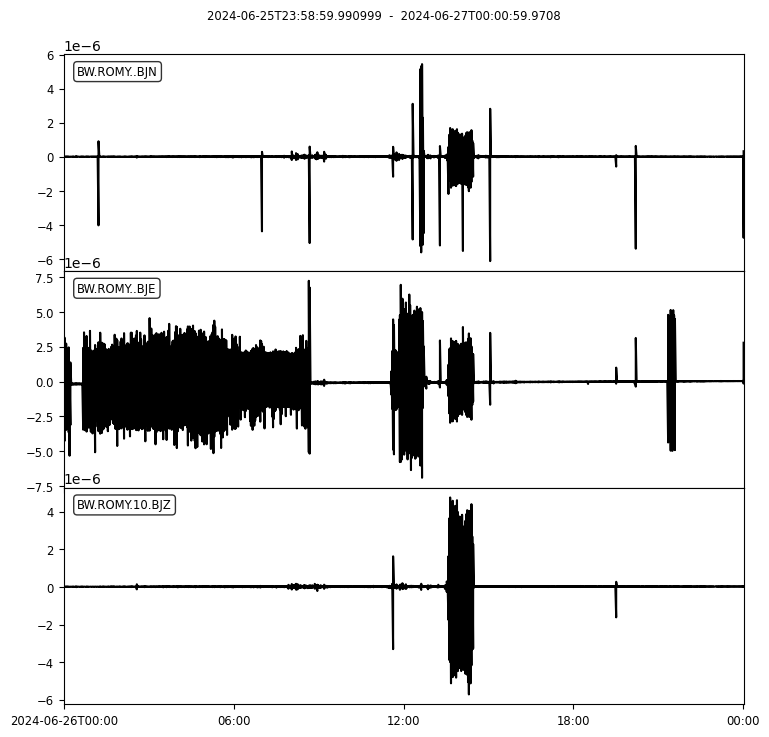

In [10]:
st0.plot(equal_scale=False);

### Load MLTI log

In [11]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

#### use MLTI log as filter

In [12]:
tr_mltiU = __get_trace("BW.ROMY.30.MLT")

tr_mltiU.data = __mlti_intervals_to_zero(tr_mltiU.data,
                                         tr_mltiU.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiU_t1,
                                         mltiU_t2,
                                         t_offset_sec=30
                                         )

In [13]:
tr_mltiV = __get_trace("BW.ROMY.30.MLT")

tr_mltiV.data = __mlti_intervals_to_zero(tr_mltiV.data,
                                         tr_mltiV.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiV_t1,
                                         mltiV_t2,
                                         t_offset_sec=30
                                         )

In [14]:
tr_mltiZ = __get_trace("BW.ROMY.30.MLT")

tr_mltiZ.data = __mlti_intervals_to_zero(tr_mltiZ.data,
                                         tr_mltiZ.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiZ_t1,
                                         mltiZ_t2,
                                         t_offset_sec=30
                                         )

### Load maintenance log

In [15]:
lxx_t1, lxx_t2 = __get_mlti_intervals(lxx.datetime)

#### use maintenance log as filter

In [16]:
tr_lxx = __get_trace("BW.ROMY.30.LXX")

tr_lxx.data = __mlti_intervals_to_zero(tr_lxx.data,
                                       tr_lxx.times(reftime=config['t1'], type="utcdatetime"),
                                       lxx_t1,
                                       lxx_t2,
                                       t_offset_sec=60
                                       )

In [17]:
# make mlti trace for horizontals (since rotated and intermixed)
tr_mltiH = tr_mltiU.copy()

# combine mlti periods
tr_mltiH.data = tr_mltiU.data + tr_mltiV.data

# remove periods with value 2 due to summation
tr_mltiH.data = where(tr_mltiH.data >= 1, 1, tr_mltiH.data)

In [36]:
# plt.plot(tr_mltiU.data)
# plt.plot(tr_mltiV.data)
# plt.plot(tr_mltiH.data)

In [18]:
# Z = st0.select(channel="*E")[0].data

# plt.figure()
# plt.plot(tr_mltiH.data)
# plt.plot(tr_lxx.data)

# plt.plot(Z)
# plt.ylim(-max(abs(Z)), max(abs(Z)))
# plt.show()

### Remove Spikes

In [19]:
%matplotlib tk

In [20]:
def despike_sta_lta(arr, df, t_lta=50, t_sta=1, threshold_upper=40, plot=False):

    from obspy.signal.trigger import recursive_sta_lta
    from obspy.signal.trigger import classic_sta_lta
    from obspy.signal.trigger import plot_trigger
    import numpy as np

    def smooth(y, npts):
        '''
        moving average of 1d signal for n samples
        '''
        win = np.hanning(npts)
        y_smooth = np.convolve(y, win/np.sum(win), mode='same')
        y_smooth[:npts//2] = np.nan
        y_smooth[-npts//2:] = np.nan
        return y_smooth

    # apply sta lta
    # cft = classic_sta_lta(arr, int(t_sta * df), int(t_lta * df))

    cft = recursive_sta_lta(arr, int(t_sta * df), int(t_lta * df))

    # plot trigger result
    if plot:
        plot_trigger(tr, cft, threshold_upper, 1, show=plot)

    # create mask from triggers
    spikes = np.where(cft < threshold_upper, 0, cft)
    spikes = np.where(spikes > threshold_upper, 1, spikes)

    # create mask with nan
    mask2 = where(spikes == 1, np.nan, spikes)
    mask2 += 1

    mask2 = smooth(mask2, 20)

    mask1 = np.nan_to_num(mask2, nan=0)

    return spikes, mask1, mask2

In [21]:
spikes = {}
masks = {}

for tr in st0:

    df = tr.stats.sampling_rate

    cha = tr.stats.channel[-1]

    data = tr.copy().data

    _data = tr.copy().data

    spikes[cha] = np.zeros(_data.size)
    masks[cha] = np.ones(_data.size)

    for i in range(20):

        # detect spikes
        _spikes, mask1, mask2 = despike_sta_lta(_data, df, t_lta=50, t_sta=1, threshold_upper=30, plot=False)

        # stop if no more spikes are detected
        if any(_sp >= 1 for _sp in _spikes):
            # apply mask
            # _data *= mask1
            _data *= mask1

            # add detected spikes
            spikes[cha] += _spikes

            # add detected spikes
            masks[cha] *= mask1

        else:
            print(f" -> stopped despiking!\n    {cha}: iteration={i}  spikes={int(sum(spikes[cha]))}")
            break

    print(f" -> finished despiking!\n    {cha}: iteration={i}  spikes={int(sum(spikes[cha]))}")

    # normalize to one (avoid accumulation)
    spikes[cha] = np.where(spikes[cha] > 1, 1, spikes[cha])

 -> finished despiking!
    N: iteration=19  spikes=710
 -> finished despiking!
    E: iteration=19  spikes=508
 -> stopped despiking!
    Z: iteration=3  spikes=82
 -> finished despiking!
    Z: iteration=3  spikes=82


In [22]:
%matplotlib tk

In [23]:
def __checkup_plot():

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 12))

    plt.subplots_adjust(hspace=0.15)

    for i, tr in enumerate(st0):

        cha = tr.stats.channel[-1]

        data_before = tr.copy().data
        data_after = data_before*masks[cha]

        ax[i].plot(spikes[tr.stats.channel[-1]], color="grey", alpha=0.6, zorder=1, label="spikes")
        ax[i].plot(data_before, label=f"{cha} before")
        ax[i].plot(data_after, label=f" {cha} after")

        ax[i].set_ylim(-np.nanmax(abs(data_after))*1.1, np.nanmax(abs(data_after))*1.1)

        ax[i].legend(loc=1)

    plt.show();
    return fig

In [24]:
fig = __checkup_plot()

# fig.savefig(config['path_to_figs']+f"{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')

del fig

## Write Data

In [25]:
outZ = obs.Stream()

outZ += st0.select(component="Z").copy()
outZ.select(component="Z")[0].stats.location = "30"
outZ += tr_mltiZ.copy()
outZ += tr_lxx.copy()

outZ = outZ.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])


In [26]:
outN = obs.Stream()

outN += st0.select(component="N").copy()
outN.select(component="N")[0].stats.location = "30"
outN += tr_mltiH.copy()
outN += tr_lxx.copy()

outN = outN.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])


In [27]:
outE = obs.Stream()

outE += st0.select(component="E").copy()
outE.select(component="E")[0].stats.location = "30"
outE += tr_mltiH.copy()
outE += tr_lxx.copy()

outE = outE.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outE, "BJE", config['path_to_sds_out'])


## Option 2

In [28]:
outZ = obs.Stream()

outZ += st0.select(component="Z").copy()
outZ.select(component="Z")[0].stats.location = "30"

data = outZ.select(component="Z")[0].data
mask = tr_mltiZ.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["Z"])

# overwrite data
outZ.select(component="Z")[0].data = dat2

# trim to defined interval
outZ = outZ.trim(config['tbeg'], config['tend'], nearest_sample=False)

outZ = outZ.split()

# __write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])

outZ.plot();

Traceback (most recent call last):
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 309, in process
    func(*args, **kwargs)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py", line 1445, in _warn_on_xaxis_zoom
    self._remove_zoomlevel_warning_text()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py", line 1457, in _remove_zoomlevel_warning_text
    ax.texts.remove(self._minmax_warning_text)
AttributeError: 'ArtistList' object has no attribute 'remove'


In [29]:
outN = obs.Stream()

outN += st0.select(component="N").copy()
outN.select(component="N")[0].stats.location = "30"

data = outN.select(component="N")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["N"])

# overwrite data
outN.select(component="N")[0].data = dat2

# trim to defined interval
outN = outN.trim(config['tbeg'], config['tend'], nearest_sample=False)

outN = outN.split()

# __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])

outN.plot();

Traceback (most recent call last):
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 309, in process
    func(*args, **kwargs)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py", line 1445, in _warn_on_xaxis_zoom
    self._remove_zoomlevel_warning_text()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py", line 1457, in _remove_zoomlevel_warning_text
    ax.texts.remove(self._minmax_warning_text)
AttributeError: 'ArtistList' object has no attribute 'remove'


In [30]:
outE = obs.Stream()

outE += st0.select(component="E").copy()
outE.select(component="E")[0].stats.location = "30"

data = outE.select(component="E")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["E"])

# overwrite data
outE.select(component="E")[0].data = dat2


outE = outE.trim(config['tbeg'], config['tend'], nearest_sample=False)

outE = outE.split()

# __write_stream_to_sds(outE, "BJE", config['path_to_sds_out'])

outE.plot();

In [31]:
# config['t1'] = obs.UTCDateTime("2024-07-01")
# config['t2'] = config['tbeg'] + 86400

# st0 = obs.Stream()

# config['path_to_sds'] = archive_path+"temp_archive/"

# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJZ", config['t1'], config['t2'])
# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJN", config['t1'], config['t2'])
# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJE", config['t1'], config['t2'])

# st0.merge(fill_value=0)

# st0.plot();